# Appendix 1 - Testing of different configurations
inner_max_num_threads is set to 1 to avoid over-subscription of CPU resources. This is because some libraries such as Numpy their own thread-pool for their computations (see [here](https://joblib.readthedocs.io/en/latest/parallel.html#avoiding-over-subscription-of-cpu-resources)).

```
n_trials = 10
inner_max_num_threads = 1
```

| n_jobs | time    | reproducible with n_jobs=1 | reproducible with n_jobs=2 | reproducible on repeat |
| ------ | ------- | -------------------------- | -------------------------- | ---------------------- |
| 1      | 12m 41s | n/a                        | n/a                        | True                   |
| 2      | 8m 59s  | False                      | n/a                        | True                   |
| 5      | 4m 12s  | False                      | True                       | True                   |
| 10     | 2m 38s  | False                      | True                       | True                   |



# Appendix 2 - Tuning CoxLASSO

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
from dill import load
from sklearn.model_selection import KFold
from sksurv.datasets import get_x_y
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from tqdm.notebook import tqdm, trange

from scjdsurv.config import SEED
from scjdsurv.preprocess import CatEncode

In [2]:
# Import imputed training data
with open('mice/imputed_train', 'rb') as file:
    imputed_train = load(file)

In [3]:
# Set number of imputed datasets
n_mice = len(imputed_train)

suggest_alphas = np.arange(1e-3,1e-1,5e-3)
search_scores = []

for alpha in tqdm(suggest_alphas):

    def cox_fold_score(train, train_i, val_i):
        
        train, val = train.iloc[train_i], train.iloc[val_i]
        
        X_train, y_train = get_x_y(train, attr_labels=['status', 'duration_m'], pos_label=True)
        X_val, y_val = get_x_y(val, attr_labels=['status', 'duration_m'], pos_label=True)
        
        # Encode data
        encoder = CatEncode()
        encoder.fit(X_train)
        X_train = encoder.transform(X_train)
        X_val = encoder.transform(X_val)
                
        cph = CoxnetSurvivalAnalysis(alphas=[alpha], l1_ratio=1.0, fit_baseline_model=True)
        cph.fit(X_train, y_train)
        model_times = cph.unique_times_
        
        def ibs(X_test, y_train, y_test):
            
            surv = cph.predict_survival_function(X_test, return_array=True)
            surv_df = pd.DataFrame(surv, columns=model_times)
            
            # check max time in test is less than in train
            while y_test['duration_m'].max() > y_train['duration_m'].max():
                tmax_i = np.where(y_test['duration_m'] == y_test['duration_m'].max())[0]
                y_test = np.delete(y_test, tmax_i)
                surv_df = surv_df.drop(tmax_i)
            
            # Find indices of event times that correspond to test data times
            indices = np.where(
                np.logical_and(
                    model_times >= min(y_test['duration_m']),
                    model_times < max(y_test['duration_m'])
                )
            )
            
            # Set times to the available timepoints
            times = model_times[indices]
            
            # subset predictions to times
            pred = surv_df[times]
            
            return integrated_brier_score(
                y_train,
                y_test,
                pred,
                times
            )
            
        return ibs(X_val, y_train, y_val)

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

    val_scores = []

    for mice_i in trange(10, leave=False):
        mean_score = np.mean([cox_fold_score(imputed_train[mice_i], train_i, val_i) for train_i, val_i in cv.split(imputed_train[mice_i])])
        val_scores.append(mean_score)

    search_scores.append(val_scores)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

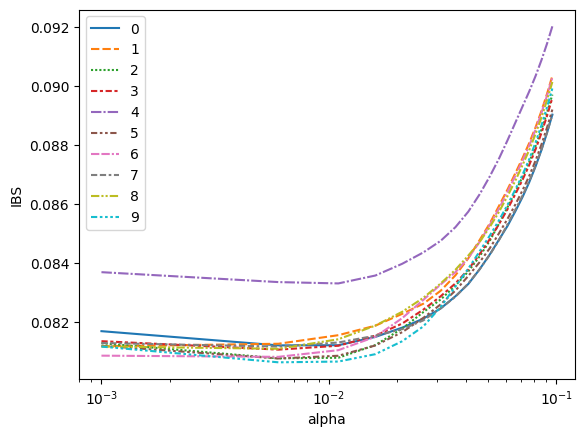

In [4]:
# Plot IBS for each M datasets
import seaborn as sns
import matplotlib.pyplot as plt

search_scores_df = pd.DataFrame(search_scores, index=suggest_alphas)
search_scores_df.index.name = 'alpha'

fig = sns.lineplot(search_scores_df)
fig.set_ylabel('IBS')
plt.xscale('log')

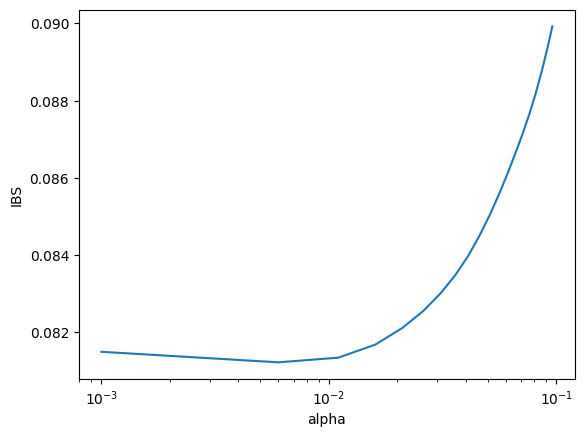

In [5]:
# Plot mean IBS across M datasets
fig = sns.lineplot(search_scores_df.mean(axis=1))
fig.set_ylabel('IBS')
plt.xscale('log')

In [6]:
# Find the best alpha by cross validation IBS
mean_M_scores = search_scores_df.mean(axis=1)
best_alpha = mean_M_scores.loc[mean_M_scores == mean_M_scores.min()].index.item()
print('Best alpha:',best_alpha)

Best alpha: 0.006
